### Summary

- Use multiple exposures to create a balanced enhanced image (HDR)

### Imports and Assets

In [1]:
# Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

URL = r"https://www.dropbox.com/s/qa1hsyxt66pvj02/opencv_bootcamp_assets_NB10.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB10.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

### HDR

- The dynamic range of an image is limited to 8-bits (0-255)
- Very bright saturation = 0
- Very dark = 255

Dark saturation can reveal detail that bright saturation can't and vice versa.

Revealing both details will enhance the image into an HDR which is something a normal camera can't focus properly

In [2]:
filenames = ["img_0.033.jpg", "img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]

# find exposure times in metadata of image
exposures = np.array([1/30, 0.25, 2.5, 15], dtype=np.float32)

# read images into cv2
images = []
for img in filenames:
    im = cv2.imread(img)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    images.append(im)

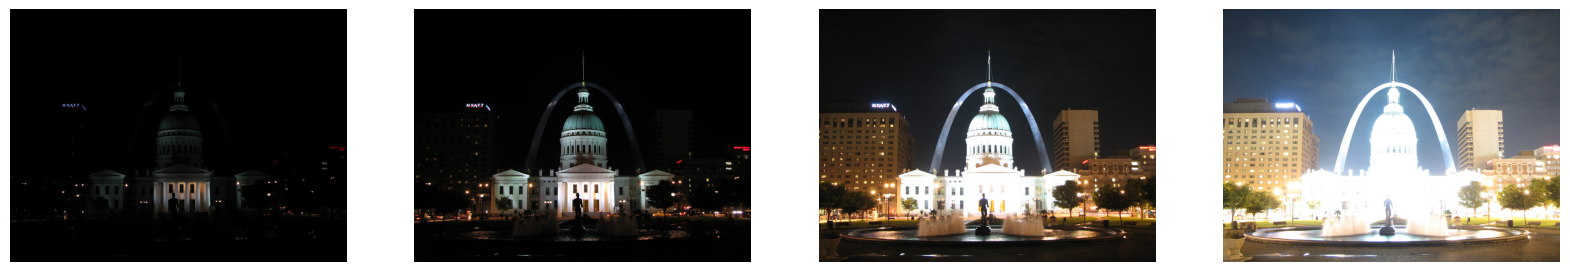

In [8]:
# display images
plt.figure(figsize=(20,4))

i = 1
for img in images:
    plt.subplot(1, 4, i)
    plt.imshow(img)
    plt.axis("off")
    i += 1

It is important to align the images perfectly in pixel because if not, the alignment with different exposures can create strange artifacts when combined (e.g. bad shape of the tower edge, strange geometry, etc.) 

The code below uses brightness to align images together.

In [9]:
# align images
align = cv2.createAlignMTB()
align.process(images, images)

Then we need to compute the camera response function (CRF)
- To make sure that scaling exposures especially while overlapping obey the function

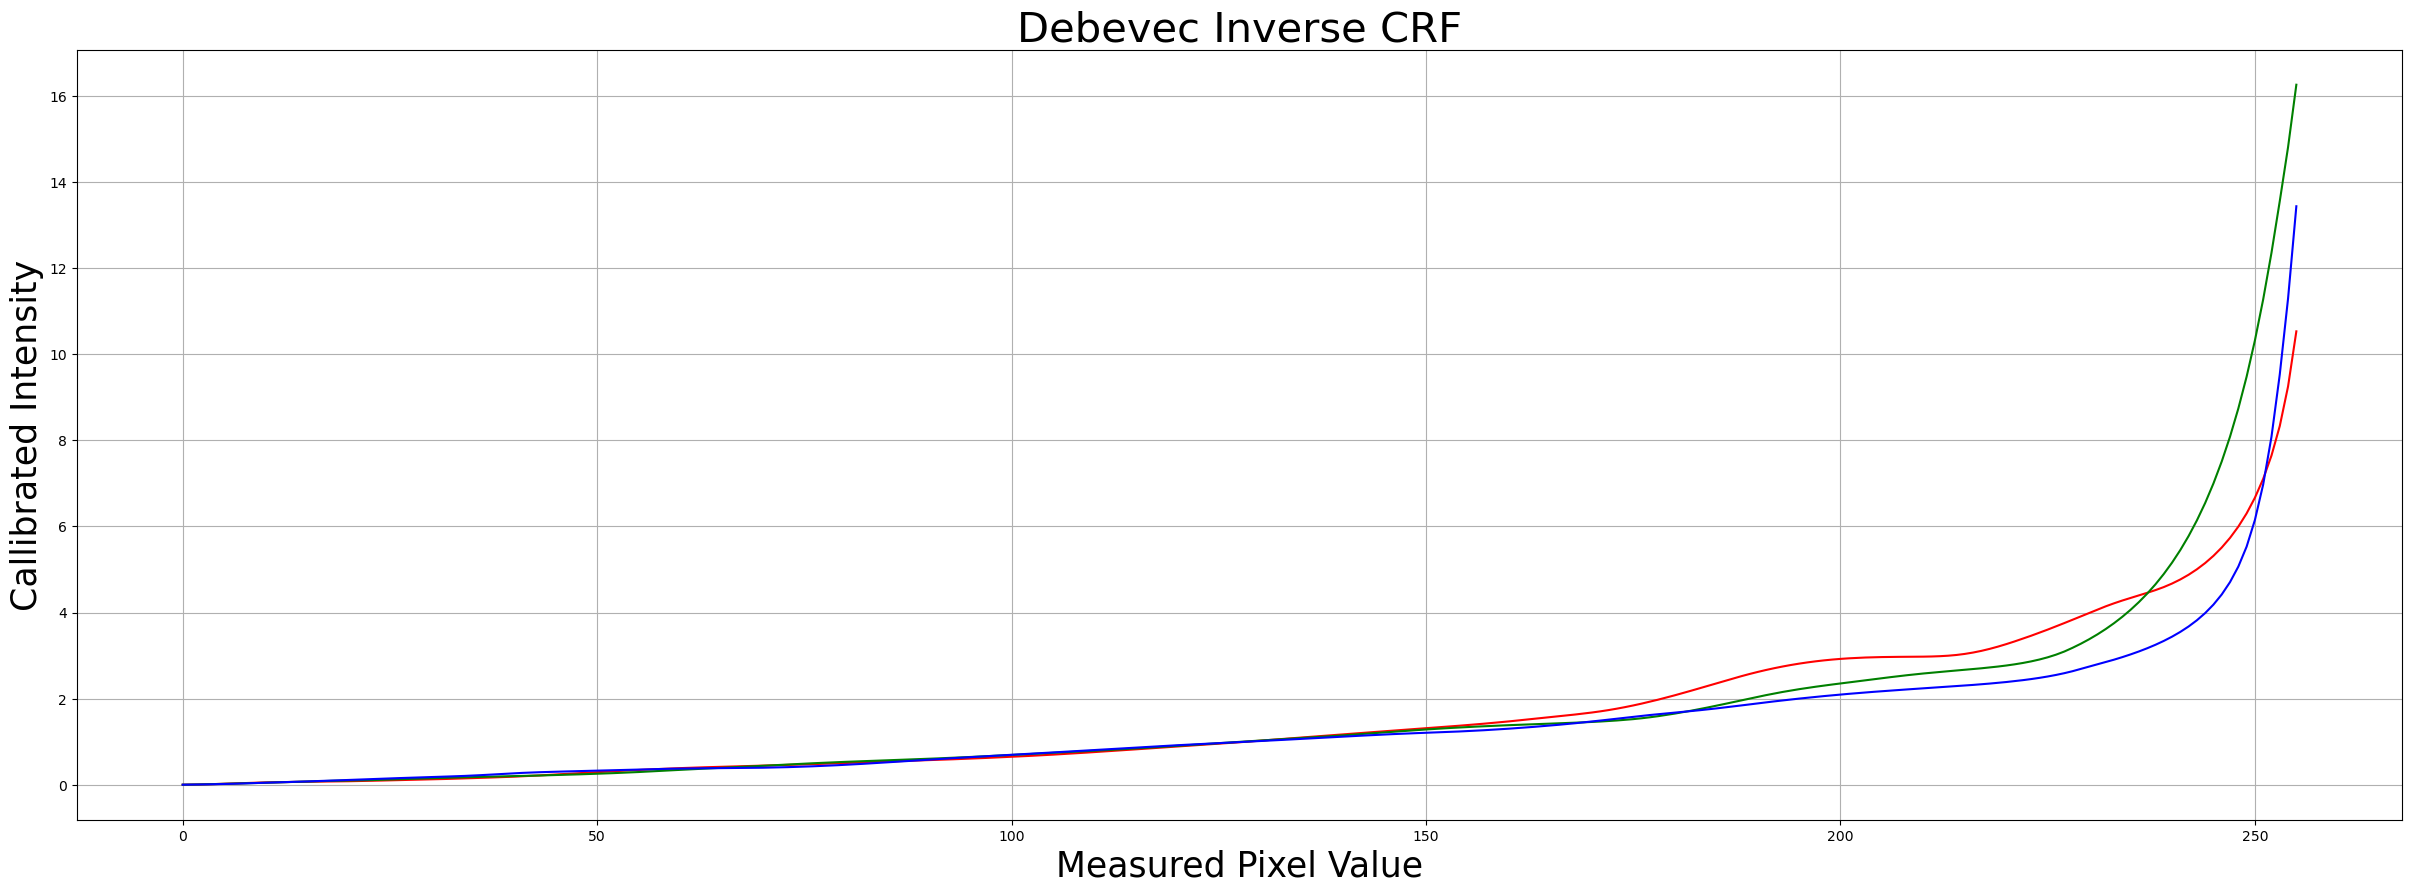

In [12]:
# find crf
calibrate_debevec = cv2.createCalibrateDebevec()
debevec_result = calibrate_debevec.process(images, exposures)

# plot crf
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(debevec_result)

plt.figure(figsize=(30, 10))
plt.title("Debevec Inverse CRF", fontsize=30)
plt.xlabel("Measured Pixel Value", fontsize=25)
plt.ylabel("Callibrated Intensity", fontsize=25)
plt.grid()
plt.plot(x, y[:, 0], 'r', x, y[:, 1], 'g', x, y[:, 2], 'b')

We then use this HDR calibration to create the HDR
    - Ignores 0 and 255 because it provides no useful information

In [14]:
# merge exposures into hdr image
merge_debevec = cv2.createMergeDebevec()
hdr_debevec = merge_debevec.process(images, exposures, debevec_result)

With this HDR, we use tonemapping to convert into the pixel range of 0 to 255 (8-bit channel). This is so that HDRs can be displayed in LDR monitors which are the common standard. 

There exists three main methods: Drago's, Reinhart's and Mantiuk's (combination of previous)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2815.5, 2111.5, -0.5)

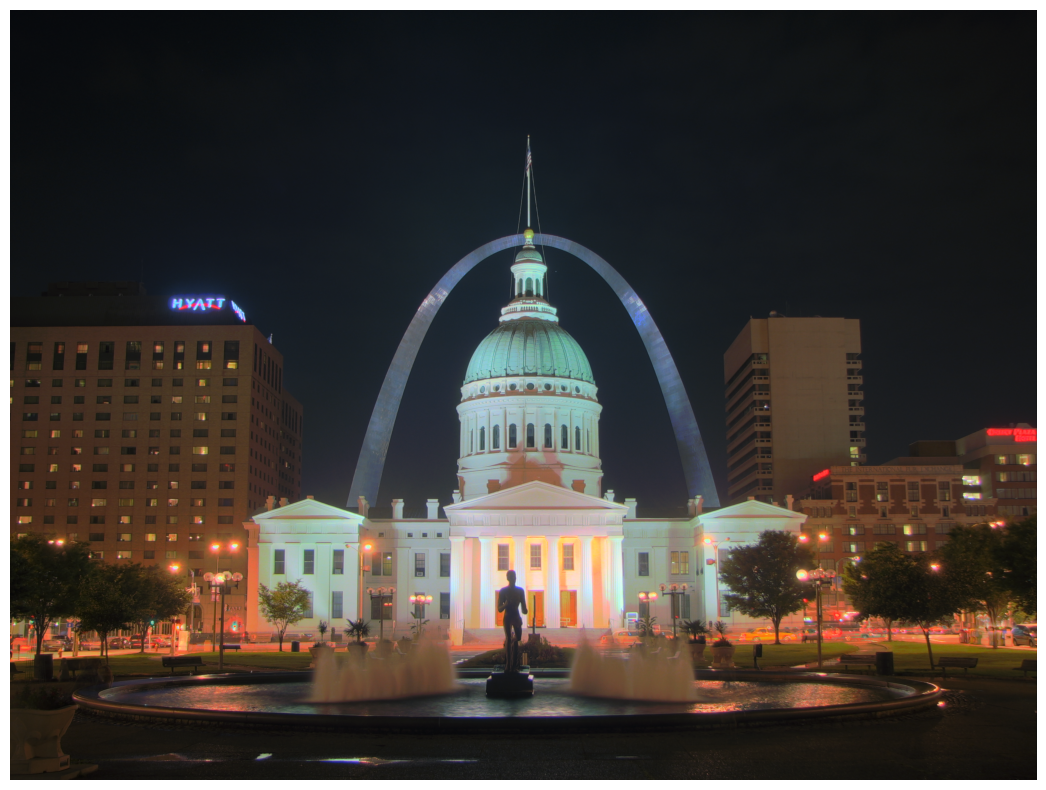

In [15]:
# tonemap with drago's 
drago = cv2.createTonemapDrago(1, 0.7)
ldr_drago = drago.process(hdr_debevec)
ldr_drago = 3 * ldr_drago

# show ldr
plt.figure(figsize=(30, 10))
plt.imshow(ldr_drago)
plt.axis("off")